# Practical 2: plotting and interpreting radar data

## 1. Introduction 

In this notebook we will make use of [The Python ARM Radar Toolkit (Py-ART)](https://arm-doe.github.io/pyart/), a Python module containing a collection of tools to processes and explore data from many types of weather radars. Py-ART can read data in common weather radar formats, produce plots (e.g. PPIs and RHIs) and apply common data corrections. In this practical, we will use Py-ART to read data from the NXPol radar, plot the data and customise the plots. You will then be able to use this to explore different data and identify meteorological features. 

First let's import Py-ART and other packages needed to run the code. For this purposes of this course, these have been installed for you but when using your own computer you will need to install Py-ART and the required dependencies. Futher details can be found [here](https://arm-doe.github.io/pyart/#install). 

In [204]:
import pyart 
import numpy as np # for working with data arrays 
import matplotlib.pyplot as plt # to make and customise plots
import cartopy.crs as ccrs # to produce maps
import glob # for accessing multiple files using wild cards (useful for finding and reading data files)
import os # for operating system dependent functionality such as manipulating file paths (useful for finding and reading data files)
import matplotlib.gridspec as gridspec #for making grids of subplots

import warnings 
warnings.simplefilter("ignore")

## 2. Reading data

As outlined in Practical 1, Py-ART can read data in common weather radar formats (e.g. Sigmet/IRIS, MDV, CF/Radial, UF, NEXRAD). We will start with an example radar file from NXPol-2.

In [205]:
data_folder = '/home/jupyter-eeslb/iar/practical2/'
radar_file = os.path.join(data_folder,'ncas-mobile-x-band-radar-1_lyneham_20230622-184423_vol_v1.0.0.nc')

When reading data we will use the [```pyart.io.read```](https://arm-doe.github.io/pyart/API/generated/pyart.io.read.html) module. ```pyart.io.read``` can automatically detect the file format, however in some cases explicitely choosing the appropriate function for the file format may be necessary. Documentation on what formats Py-ART can read can be found [here](https://arm-doe.github.io/pyart/API/generated/pyart.io.html). NXPol data is in the common CF-radial format so we can simply use ```pyart.io.read```. Setting ```delay_field_loading=True``` delays loading of data from the file until it is accessed, this can speed up loading. 

In [206]:
radar = pyart.io.read(radar_file, delay_field_loading=True)

When we run this, we get a [```pyart.Radar``` object](https://arm-doe.github.io/pyart/API/generated/pyart.core.Radar.html#pyart.core.Radar), within which the variables are stored in dictionaries or dictionaries of dictionaries. (Note: for more information on Python dictionaries see [here](https://docs.python.org/3/tutorial/datastructures.html#dictionaries)). Let's have a look using the ```radar.info``` method. 

As you can see, this gives a complete picture of what is in the file. Information about the radar, data processing and observational period can be found in the ```radar.metadata``` attribute. Variables relating to the scans are stored in dictionaries that contain the data as well important information such as the units and variable name (according to C/F conventions). We can access these using the radar object and the variable name. For example, we can look at the elevation. 

In [207]:
radar.elevation

{'units': 'degrees',
 '_FillValue': -9999.0,
 'positive': 'up',
 'long_name': 'elevation_angle_from_horizontal_plane',
 'standard_name': 'ray_elevation_angle',
 'axis': 'radial_elevation_coordinate',
 'data': masked_array(data=[1. , 1. , 1. , ..., 6.5, 6.5, 6.5],
              mask=False,
        fill_value=1e+20,
             dtype=float32)}

The ```fields``` attribute stores the actual measurement data such as reflectivity and velocity in a dictionary of dictionaries. To see what fields are present let's access the dictionary keys.

In [208]:
radar.fields.keys()

dict_keys(['CCOR', 'CCORv', 'KDP', 'PhiDP', 'RhoHV', 'RhoHVu', 'SNR', 'SNRu', 'SNRv', 'SNRvu', 'SQI', 'SQIu', 'SQIv', 'SQIvu', 'V', 'Vu', 'Vv', 'Vvu', 'W', 'Wu', 'Wv', 'Wvu', 'ZDR', 'ZDRu', 'dBZ', 'dBZv', 'dBuZ', 'dBuZv', 'uKDP', 'uKDPu', 'uPhiDP', 'uPhiDPu'])

To look at an individual field we can use the variable name to access the relevant dictionary. For example, to look at the horizontal reflectivity we use ```'dBZ'```. Note that because we set ```delay_field_loading=True``` when reading the data the field attribute contains LazyLoadDict objects no dict objects and the field data is not loaded until the 'data' key is accessed. To have a look at the dictionary we need to print the field and not just call ```radar.fields['dBZ']``` as we could with a normal dict object.

In [209]:
print(radar.fields['dBZ'])

{'long_name': 'reflectivity_from_horizontal_polarization', 'proposed_standard_name': 'radar_equivalent_reflectivity_factor_h', 'units': 'dBZ', 'sampling_ratio': 1.0, '_FillValue': -9e+33, 'grid_mapping': 'grid_mapping', 'coordinates': 'elevation azimuth range', 'data': LazyLoad(<pyart.io.cfradial._NetCDFVariableDataExtractor object at 0x7f44c619ada0>)}


Within each field the data itself is stored under the ```'data'``` key which can be added to the call to extract the data array from the dictionary.

In [210]:
reflectivity = radar.fields['dBZ']['data']
reflectivity

masked_array(
  data=[[6.5, 18.0, 15.0, ..., --, --, --],
        [12.0, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [4.0, -1.5, -13.0, ..., --, --, --],
        [8.0, -8.0, -9.5, ..., --, --, --],
        [5.5, -7.5, -17.0, ..., --, --, --]],
  mask=[[False, False, False, ...,  True,  True,  True],
        [False,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],
  fill_value=-9e+33,
  dtype=float32)

## 3. Plotting PPIs

### 3.1 Simple PPI plots
Having read in the data, we can now make some plots. Py-ART has built in visualisation classes for plotting PPIs, RHIs and individual ray traces in the [```pyart.graph``` module](https://arm-doe.github.io/pyart/API/generated/pyart.graph.html). 

The first step to producing a plot using Py-ART is to initilize a [radar display object](https://arm-doe.github.io/pyart/API/generated/pyart.graph.RadarDisplay.html) using our radar object as the input to the function. 

In [211]:
display = pyart.graph.RadarDisplay(radar)

Once the the map display is initialized we can add a plot to it Py-ART's plotting functions. The types of plots available can be found in the [```RadarDisplay``` documentation](https://arm-doe.github.io/pyart/API/generated/pyart.graph.RadarDisplay.html#pyart.graph.RadarDisplay). The data we have loaded is from NXPol used in PPI mode, meaning the elevation angle is constant but the azimuth angle varies (i.e. the radar rotates through 360 degrees). We can display this data on a 2D PPI plot with the radar in the centre. 

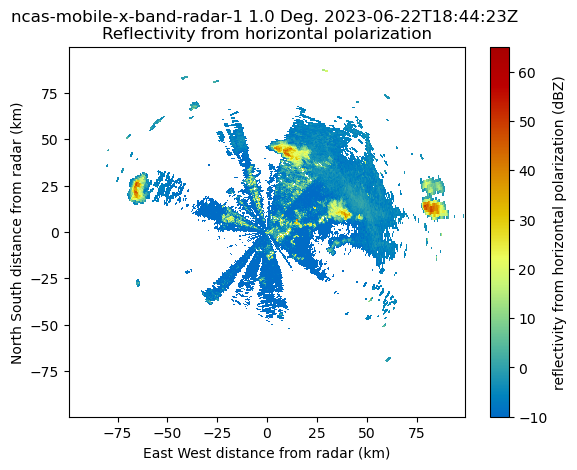

In [212]:
display.plot_ppi('dBZ')

This plot is at 1.5 deg elevation angle. Have a look at the ```radar.nsweeps``` attribute to see how many sweeps there. 

In [213]:
# how many sweeps are there?


We can specify the sweep index when making the plot to choose a different elevation angle. Note: try ```np.unique(radar.elevation['data'])``` to see what elevation angles there are.

In [214]:
# what elevation angles are there?


We can now try plotting different elevations angles by giving the sweep index to the plotting function. 

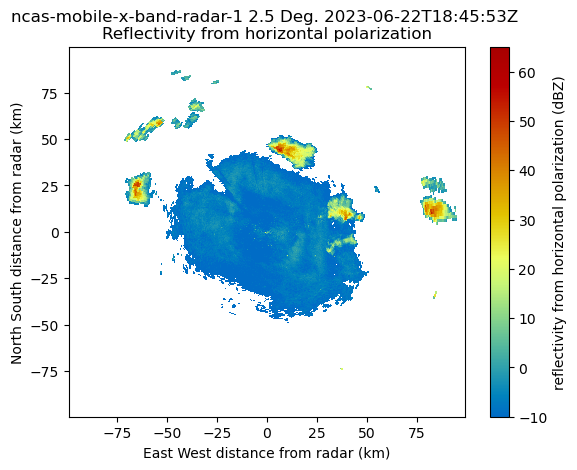

In [215]:
display.plot_ppi('dBZ', 2) 

As well as plotting the PPI we can add other useful details to the map such as range rings and crosshairs to show the location of the radar. Each plotting function also takes various input variables, outlined in the documentation (e.g. [```plot_ppi``` documentation](https://arm-doe.github.io/pyart/API/generated/pyart.graph.RadarDisplay.plot_ppi.html#pyart.graph.RadarDisplay.plot_ppi)), that we can play with to being to customise the plot. Let's see what we can do. 

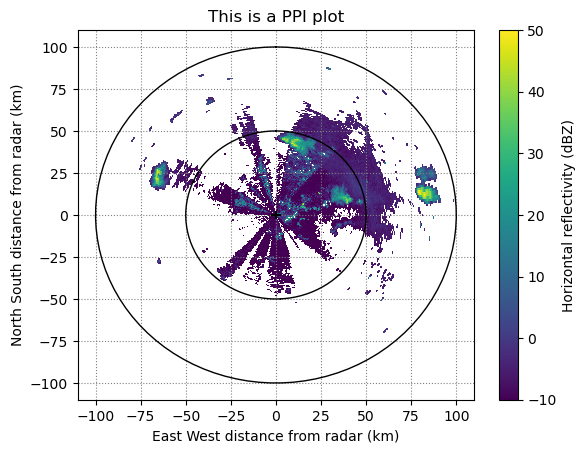

In [216]:
display.plot_ppi('dBZ', 
                 sweep = 0, # sweep index
                 vmin = -10, # lower limit of colourscale 
                 vmax = 50, # upper limit of colourscale 
                 title = 'This is a PPI plot', # set title (can also be turned off using title_flag = False)
                 colorbar_label  = 'Horizontal reflectivity (dBZ)', # set colourbar label
                 cmap = 'viridis'
                )

display.plot_range_rings([50,100], # list of locations to draw range rings in km from radar
                         ls = '-', #linestyle
                         lw = '1' #linewidth
                         ) 

display.plot_cross_hair(2) # size in km

display.plot_grid_lines(col = 'gray', # colour
                        ls = ':' # linestyle 
                        ) 

### 3.2 Choosing colourmaps

As you can see, we've changed the colourmap in the plot above. However, the choice of which colourmap you use to represent the data is important. Check out [this document](https://scientifictraining-ncas.talentlms.com/unit/view/id:2690) on choosing colourmaps and then decide what would be best to use for horizontal reflectivity and radial velocity. Make a new plot to show radial velocity. 

In [217]:
# plot velocity


### 3.3 Creating a map
Our PPI plot is a good start but it is usually beneficial to know where our radar is located. Luckily for us, Py-ART can also create plots on a geographic map using [Cartopy](https://scitools.org.uk/cartopy/docs/latest/). The process is similar to what we have just done, but rather than a radar display object we inizialize a [radar map display object](https://arm-doe.github.io/pyart/API/generated/pyart.graph.RadarMapDisplay.html) upon which we can plot a PPI map.

/opt/tljh/user/lib/python3.10/site-packages/pyart/graph/radarmapdisplay.py:317: UserWarning: No projection was defined for the axes. Overridding defined axes and using default axes with projection Lambert Conformal.
  warnings.warn(


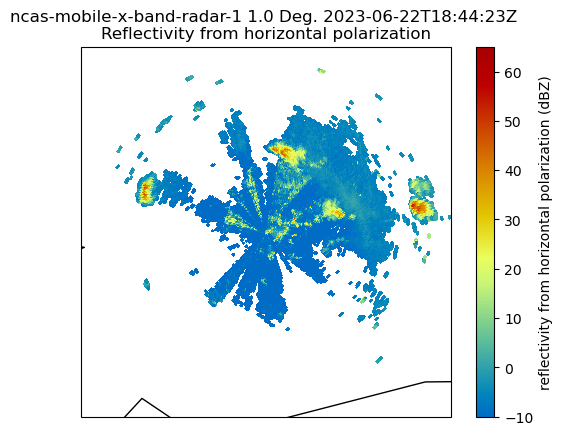

In [218]:
warnings.simplefilter("default")

display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map('dBZ', 0)

As you can see, we now have some new features (but what are they?) and the X, Y labels in distance from the radar are no longer present. You may also have noticed an error informing you that no projection has been defined for the axes. When creating a map, the projection defines the set of transformations used to flatten the curved surface of the globe on to a plane. It is impossible to do this without some sort of distortion, and different map projections distort the globe in different ways. Some projections maintain the shape of objects but distort their area, leading to some places appearing much larger than they are. Others maintain the area but distort their shape, leading to places appearing squashed or stretched. The 'best' projection to use varies depending on the desired use, location and data being plotted. For radar data, the azimuthal equidistant projection centred on the radar is a good choice because this projection preserves distance and direction from the central point. 

We can get the radar longitude and latitude from the radar object and use these to define the Cartopy projection to be used. 

In [219]:
grid_projection = ccrs.AzimuthalEquidistant(central_longitude=radar.longitude['data'][0],
                                            central_latitude=radar.latitude['data'][0]
                                           )

Checking out the [```plot_ppi_map``` documentation](https://arm-doe.github.io/pyart/API/generated/pyart.graph.RadarMapDisplay.plot_ppi_map.html) shows how we can set the projection when plotting the map and gives additional ways we can customise the plots, for example changing the map resolution.

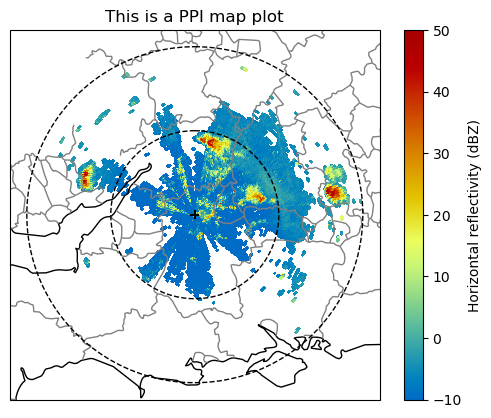

In [220]:
warnings.simplefilter("ignore")

display.plot_ppi_map('dBZ', # field 
                     sweep = 0, #sweep index
                     resolution = '10m', #map resolution
                     vmin = -10, # lower limit of colourscale 
                     vmax = 50, # upper limit of colourscale 
                     title = 'This is a PPI map plot', #plot title (can also be turned off using title_flag = False)
                     colorbar_label  = 'Horizontal reflectivity (dBZ)', #colourbar label
                     projection = grid_projection
                    )

display.plot_range_rings([50,100], 
                         ls = '--',
                         lw = '1')

display.plot_cross_hair(2000)

### 3.4 Customising and saving plots 

Py-ART plotting functions are great however the customisations can sometimes be limited, and you may wish to personalise things more. Since Py-ART plotting is built upon matplotlib and cartopy we can use these as we would with any other type of plotting by turning off the embellishments added by Py-ART and adding our own. We can also add other features to the map, for example plotting the location of Chilbolton Atmospheric Observatory. 

We can also save the figure using matplotlib's [```savefig```] function (https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html) with filenames created from the radar file paths. You can also dynamically update output file names in a loop when making multiple plots. I recommend creating a folder in your home directory and then set this as your ```plot_directory```.

In [221]:
plot_directory = '/home/jupyter-eeslb/plots'

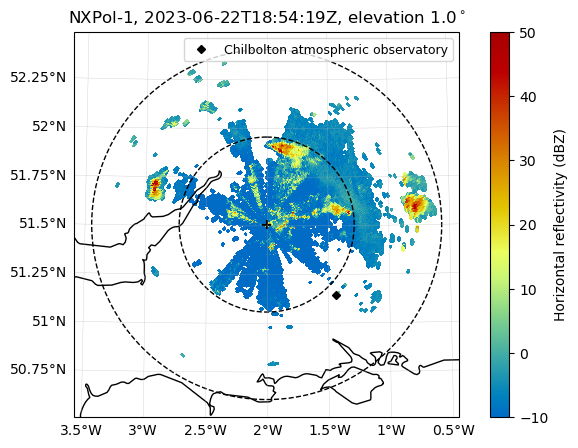

In [235]:
sweep_idx = 0 # choose sweep index to plot

# set up figure and axes
fig = plt.figure(figsize=(8,5))
ax = plt.subplot(111, projection=grid_projection) 

# plot ppi
display.plot_ppi_map('dBZ',
                 sweep = sweep_idx,
                 ax = ax, # set which axes to create the plot on 
                 embellish = False, # turn off embellishments such as coastlines
                 title_flag = False, # turn off title
                 projection = grid_projection, # set projection
                 vmin = -10, #lower limit of colourbar
                 vmax = 50, #upper limit of colourbar
                 colorbar_label  = 'Horizontal reflectivity (dBZ)',
                 cmap = 'pyart_HomeyerRainbow'
                )

# add coastlines to plot (this adds coastlines only, without the admin boundaries that Py-ART includes)
ax.coastlines(resolution = '10m');

# plot range ringes
display.plot_range_rings([50,100], 
                         ls = '--',
                         lw = '1'
                        )

# plot cross hair
display.plot_cross_hair(2000, ax = ax) 

# add gridlines 
gl = ax.gridlines(draw_labels=True,
                  dms = False,
                  x_inline=False,
                  y_inline=False,
                  rotate_labels=False,
                  alpha = 0.7,
                  zorder = 0,
                  linewidth = 0.25,
                  )
gl.right_labels = gl.top_labels = False

# plot Chilbolton location
chilbolton_lon, chilbolton_lat = -1.43858, 51.14456
ax.plot(chilbolton_lon, chilbolton_lat, 
        transform = ccrs.PlateCarree(), 
        linestyle = '',
        marker = 'D',
        markersize = 4,
        color = 'black',
        label = 'Chilbolton atmospheric observatory'
       )

# add legend
ax.legend(loc = 'upper right',fontsize = 9);

# set up title and add 
start_dt = radar.metadata['start_datetime'] #get date and time from radar metadata
elevation = np.unique(radar.elevation['data'])[sweep_idx] #get actual elevation angle from sweep index
instrument = 'NXPol-1'
title = f'{instrument}, {start_dt}, elevation {elevation}$^\\circ$' #join all together
ax.set_title(title, fontsize = 12)

# saving
in_file = radar_file.split('/')[-1] #get file name from path
file_name = os.path.splitext(in_file)[0] # split file extension from file name
plot_type = 'PPI_dBZ' # choose details to include in plot file name 
out_file = f'{file_name}_{plot_type}.png' #join output file name 
out_fpath = os.path.join(out_directory,out_file) #full output file path

# save figure (you can also use plt.savefig to save latest plot if you have not used 'fig=...')
fig.savefig(out_fpath)

### 3.5 Plotting multiple variables on subplots 

It is often useful to look at multiple varibles at the same time, we can plot them on subplots. 

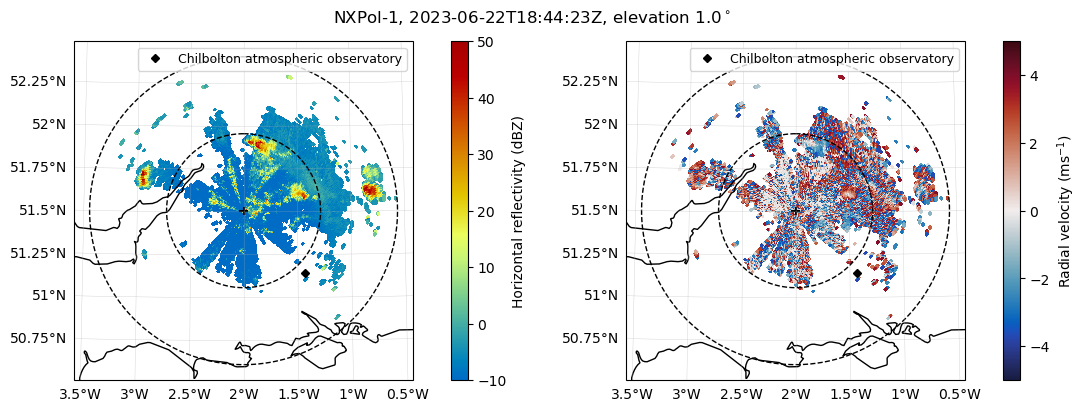

In [223]:
sweep_idx = 0

# set up figure 
fig = plt.figure(figsize=(11,4), constrained_layout = True)
ax1 = plt.subplot(121, projection=grid_projection) #add subplot
ax2 = plt.subplot(122, projection=grid_projection) #add subplot

# loop over variables and plot
axes = [ax1,ax2]
plot_variables = ['dBZ','V'] #variables to plot 
cbar_labels = ['Horizontal reflectivity (dBZ)', 'Radial velocity (ms$^{-1}$)'] #colourbar labels
cmaps = ['HomeyerRainbow', 'balance'] #colourmap for each variable
vlims = [(-10,50),(-5,5)] #vmin and vmax for each variable
for ax,field,cbar_label,cmap,vlim in zip(axes,plot_variables, cbar_labels, cmaps, vlims):
    display.plot_ppi_map(field,
                     sweep = sweep_idx,
                     ax = ax, # set which axes to create the plot on 
                     embellish = False, # turn off embellishments such as coastlines
                     title_flag = False, # turn off title
                     projection = grid_projection, # set projection
                     vmin = vlim[0], #lower limit
                     vmax = vlim[1], #upper limit
                     colorbar_label=cbar_label,
                     cmap = cmap                     
                    )
    
    # add coastlines
    ax.coastlines(resolution = '10m');
    
    # plot range ringes
    display.plot_range_rings([50,100],
                             ls = '--',
                             lw = '1')
    
    # plot cross hair
    display.plot_cross_hair(2000, ax = ax) 
    
    # add gridlines 
    gl = ax.gridlines(draw_labels=True,
                      dms = False,
                      x_inline=False,
                      y_inline=False,
                      rotate_labels=False,
                      alpha = 0.7,
                      zorder = 0,
                      linewidth = 0.25,
                      )
    gl.right_labels = gl.top_labels = False
    
    # plot Chilbolton location
    chilbolton_lon, chilbolton_lat = -1.43858, 51.14456
    ax.plot(chilbolton_lon, chilbolton_lat, 
            transform = ccrs.PlateCarree(), 
            linestyle = '',
            marker = 'D',
            markersize = 4,
            color = 'black',
            label = 'Chilbolton atmospheric observatory'
           )
    
    # add legend
    ax.legend(loc = 'upper right',fontsize = 9);

# set up figure title and add 
start_dt = radar.metadata['start_datetime']
elevation = np.unique(radar.elevation['data'])[sweep_idx]
instrument = 'NXPol-1'
title = f'{instrument}, {start_dt}, elevation {elevation}$^\\circ$'
fig.suptitle(title); #add title to figure rather than individual axes to span both subplots

## 4. Plotting RHIs 

As well as PPI scans, NXPol can also run in Range Height Indicator (RHI) mode, meaning the azimuth angle is fixed but the elevation changes, leading to data in the vertical plane. We can make RHI plots using Py-ART by once again initilizing a radar display and then using the [```display.plot_rhi```](https://arm-doe.github.io/pyart/API/generated/pyart.graph.RadarDisplay.plot_rhi.html) function. 

### 4.1 Simple RHI plots from RHI scans

In [224]:
radar_file = os.path.join(data_folder,'ncas-mobile-x-band-radar-1_lyneham_20230612-151859_rhi_v1.0.0.nc')
radar = pyart.io.read(radar_file, delay_field_loading=True)

We can look in the file to check what azimuth angle this scan was at using the ```azimuth``` attribute

In [225]:
# what is the azimuth angle?


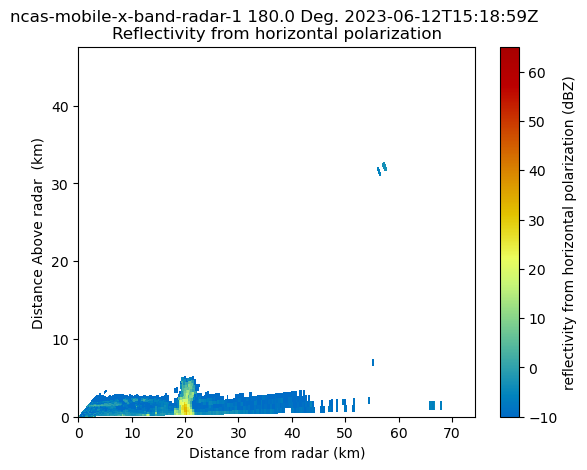

In [226]:
display = pyart.graph.RadarDisplay(radar)
display.plot_rhi('dBZ')

We can make subplots and customise them in a similar way to our previous plots. 

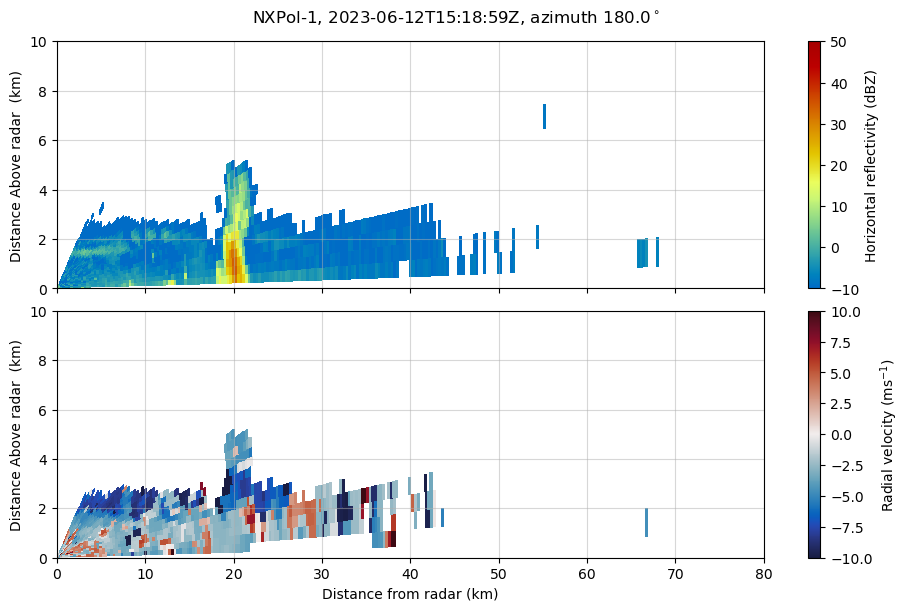

In [227]:
# set up figure and axes
fig = plt.figure(figsize=(9,6), constrained_layout = True) 
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

#loop over variables and plot
axes = [ax1,ax2]
plot_variables = ['dBZ','V']
cbar_labels = ['Horizontal reflectivity (dBZ)', 'Radial velocity (ms$^{-1}$)']
cmaps = ['HomeyerRainbow', 'balance']
vlims = [(-10,50),(-10,10)]
for ax,field,cbar_label,cmap,vlim in zip(axes,plot_variables, cbar_labels, cmaps, vlims):
    display.plot_rhi(field,
                     ax = ax,
                     title_flag = False,
                     vmin = vlim[0],
                     vmax = vlim[1],
                     colorbar_label=cbar_label,
                     cmap = cmap)

    # change axes limits
    ax.set_ylim([0,10])
    ax.set_xlim([0,80])
    
    # add grid to axes
    ax.grid(alpha = 0.5,
            zorder = 0)

    # remove inner axes labels on subplots 
    ax.label_outer()

# set up title and add 
start_dt = radar.metadata['start_datetime']
azimuth = radar.azimuth['data'][0]
instrument = 'NXPol-1'
title = f'{instrument}, {start_dt}, azimuth {azimuth}$^\\circ$'
fig.suptitle(title);

### 4.2 Pseudo RHI plots from volume scans

Where RHI scans are not available it is possible to take a slice through a PPI volume scan and make a psuedo RHI plot using the  [```plot_azibuth_to_rhi```](https://arm-doe.github.io/pyart-docs-travis/API/generated/pyart.graph.RadarDisplay.plot_azimuth_to_rhi.html) module.

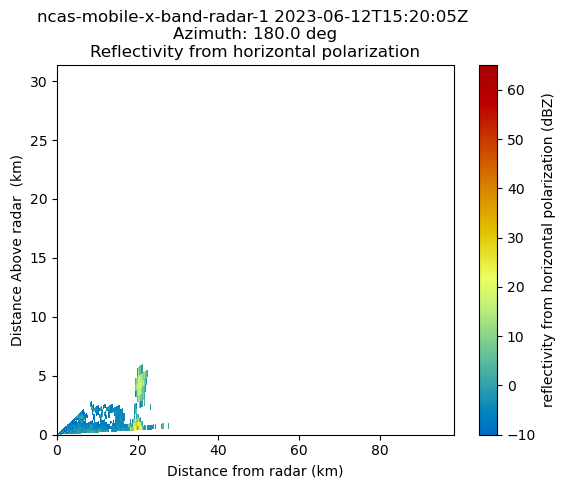

In [228]:
radar_file = os.path.join(data_folder,'ncas-mobile-x-band-radar-1_lyneham_20230612-152005_vol_v1.0.0.nc')
radar = pyart.io.read(radar_file, delay_field_loading=True)

display = pyart.graph.RadarMapDisplay(radar)
display.plot_azimuth_to_rhi('dBZ',
                            180) # choose azimuth to plot )

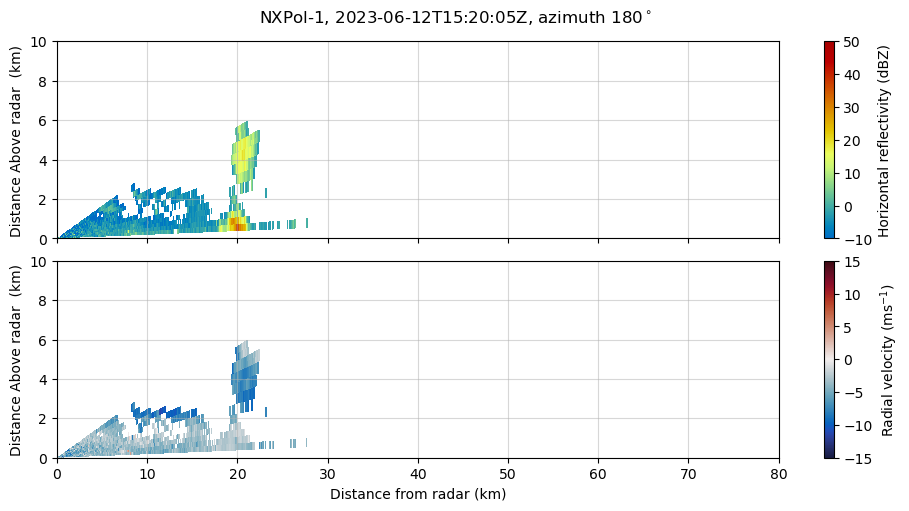

In [229]:
azimuth = 180 # select azimuth to plot

#set up figure
fig = plt.figure(figsize=(9,5), constrained_layout = True) 
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

#loop over variables and plot
axes = [ax1,ax2]
plot_variables = ['dBZ','V']
cbar_labels = ['Horizontal reflectivity (dBZ)', 'Radial velocity (ms$^{-1}$)']
cmaps = ['HomeyerRainbow', 'balance']
vlims = [(-10,50),(-15,15)]
for ax,field,cbar_label,cmap,vlim in zip(axes,plot_variables, cbar_labels, cmaps, vlims):
    display.plot_azimuth_to_rhi(field, 
                                azimuth, 
                                ax = ax, 
                                title_flag = False, # turn off title
                                vmin = vlim[0],
                                vmax = vlim[1],
                                colorbar_label=cbar_label,
                                cmap = cmap
                               )
    # change axes limits
    ax.set_ylim([0,10])
    ax.set_xlim([0,80])

    # add grid to axes
    ax.grid(alpha = 0.5,
            zorder = 0)

    # remove inner axes labels on subplots 
    ax.label_outer()

# set up title and add 
start_dt = radar.metadata['start_datetime']
instrument = 'NXPol-1'
title = f'{instrument}, {start_dt}, azimuth {azimuth}$^\\circ$'
fig.suptitle(title);

### 4.3 Combine PPI and pseudo RHI plots

Since these RHI plots are created from a volume scan we can also plot the associated PPI. 

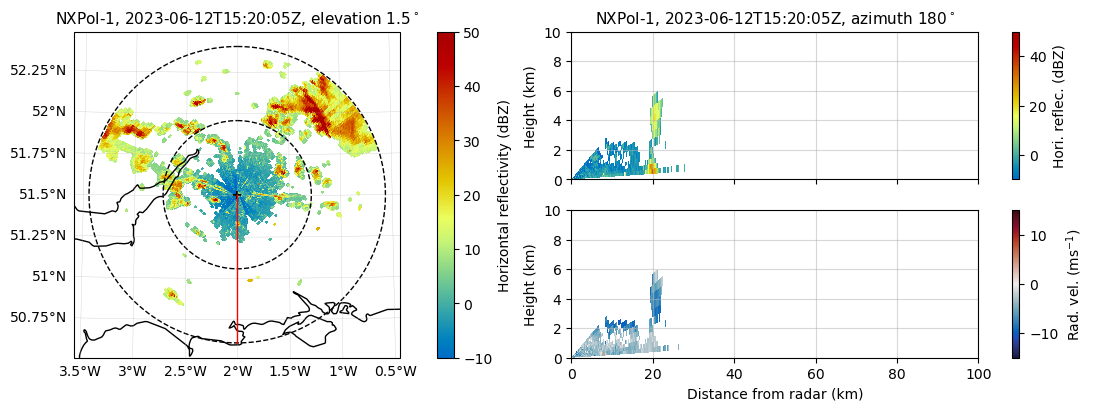

In [230]:
azimuth = 180 #choose azimuth
sweep_idx = 0 #choose sweep index 

# set up figure and gridspec (allows more customisation for more complicated subplots)
nrows = 2
ncols = 2
fig = plt.figure(figsize=(11,4), constrained_layout = True)
gs = gridspec.GridSpec(nrows, ncols, figure = fig)

#add geoaxes for PPI plot, in first column but spanning both rows
ax1 = plt.subplot(gs[0:,0],projection=grid_projection) 

#add axes for rhi plots in second column
ax2 = plt.subplot(gs[0,1]) 
ax3 = plt.subplot(gs[1,1], sharex = ax2)

# plot PPI
display.plot_ppi_map('dBZ', # field 
                     sweep = sweep_idx, # sweep index
                     ax= ax1,
                     title_flag = False,
                     embellish = False,
                     vmin = -10, 
                     vmax = 50, # upper limit of colourscale 
                     colorbar_label  = 'Horizontal reflectivity (dBZ)', # set colourbar label
                     projection = grid_projection,
                    )

display.plot_range_rings([50,100], 
                         ls = '--',
                         lw = '1')

display.plot_cross_hair(2000, ax = ax1)
ax1.coastlines(resolution = '10m');

# add gridlines 
gl = ax1.gridlines(draw_labels=True,
                  dms = False,
                  x_inline=False,
                  y_inline=False,
                  rotate_labels=False,
                  alpha = 0.7,
                  zorder = 0,
                  linewidth = 0.25,
                  )

gl.right_labels = gl.top_labels = False

## plot line at chosen azimuth 
r = 100
azimuth_rad = np.radians(90-azimuth) 
max_lat  = radar.latitude['data'][0]  + np.sin(azimuth_rad) * (r / 6378 ) * (180 / np.pi)
max_lon = radar.longitude['data'][0] +  np.cos(azimuth_rad) * (r / 6378 ) * (180 / np.pi) / np.cos(radar.latitude['data'][0] * np.pi/180)

display.plot_line_geo([radar.longitude['data'][0], max_lon], [radar.latitude['data'][0], max_lat], line_style='-', 
                       lw=1, color='red', transform=ccrs.PlateCarree())

## plot RHIs
axes = [ax2,ax3]
plot_variables = ['dBZ','V']
cbar_labels = ['Hori. reflec. (dBZ)', 'Rad. vel. (ms$^{-1}$)']
cmaps = ['HomeyerRainbow', 'balance']
vlims = [(-10,50),(-15,15)]

for ax,field,cbar_label,cmap,vlim in zip(axes,plot_variables, cbar_labels, cmaps, vlims):
    display.plot_azimuth_to_rhi(field, 
                                azimuth, 
                                ax = ax, 
                                vmin = vlim[0],
                                vmax = vlim[1],
                                title_flag = False, # turn off title
                                axislabels_flag=False,
                                colorbar_label=cbar_label,
                                cmap = cmap
                               )
    
    ax.set_ylim([0,10])
    ax.set_xlim([0,100])
    ax.grid(alpha = 0.5,
            zorder = 0)
    ax.set_ylabel('Height (km)')
    #ax.label_outer()

ax2.tick_params(labelbottom=False)
ax3.set_xlabel('Distance from radar (km)');

# set up titles for each subplot and add 
start_dt = radar.metadata['start_datetime']
elevation = np.unique(radar.elevation['data'])[sweep_idx]
instrument = 'NXPol-1'
title_ppi = f'{instrument}, {start_dt}, elevation {elevation:.1f}$^\\circ$'
title_rhi = f'{instrument}, {start_dt}, azimuth {azimuth}$^\\circ$'
ax1.set_title(title_ppi, fontsize = 11)
ax2.set_title(title_rhi, fontsize = 11);

### 5. Looping over multiple files
We usually want to look at how things are changing over time, so plotting multiple scans is useful. We can list all the files in the directory using ```os```.

In [231]:
files = os.listdir(data_folder)
files

['ncas-radar-mobile-ka-band-1_lyneham_20230708-091700_hsrhi_l1_v0.1.1.nc',
 'ncas-mobile-x-band-radar-1_lyneham_20230612-152005_vol_v1.0.0.nc',
 'ncas-mobile-x-band-radar-1_lyneham_20230622-183423_vol_v1.0.0.nc',
 'ncas-mobile-x-band-radar-1_lyneham_20230612-151859_rhi_v1.0.0.nc',
 'ncas-mobile-x-band-radar-1_lyneham_20230622-184423_vol_v1.0.0.nc',
 'ncas-mobile-x-band-radar-1_lyneham_20230622-185419_vol_v1.0.0.nc',
 'ncas-mobile-x-band-radar-1_lyneham_20230622-182423_vol_v1.0.0.nc']

We don't want to plot all of these, so we can use ```glob``` to find pathnames matching a specified pattern

In [232]:
from glob import glob

date = '20230622'
file_name = f'ncas-mobile-x-band-radar-1_lyneham_{date}*vol_*'
file_path = os.path.join(data_folder,file_name)
files = glob(file_path)
files

['/home/jupyter-eeslb/iar/practical2/ncas-mobile-x-band-radar-1_lyneham_20230622-183423_vol_v1.0.0.nc',
 '/home/jupyter-eeslb/iar/practical2/ncas-mobile-x-band-radar-1_lyneham_20230622-184423_vol_v1.0.0.nc',
 '/home/jupyter-eeslb/iar/practical2/ncas-mobile-x-band-radar-1_lyneham_20230622-185419_vol_v1.0.0.nc',
 '/home/jupyter-eeslb/iar/practical2/ncas-mobile-x-band-radar-1_lyneham_20230622-182423_vol_v1.0.0.nc']

To make sure we plot the files in data order it is good practice to sort them.

In [233]:
files.sort()
files

['/home/jupyter-eeslb/iar/practical2/ncas-mobile-x-band-radar-1_lyneham_20230622-182423_vol_v1.0.0.nc',
 '/home/jupyter-eeslb/iar/practical2/ncas-mobile-x-band-radar-1_lyneham_20230622-183423_vol_v1.0.0.nc',
 '/home/jupyter-eeslb/iar/practical2/ncas-mobile-x-band-radar-1_lyneham_20230622-184423_vol_v1.0.0.nc',
 '/home/jupyter-eeslb/iar/practical2/ncas-mobile-x-band-radar-1_lyneham_20230622-185419_vol_v1.0.0.nc']

Now you could loop through each file and create a seperate figure, or create one figure with multiple subplots:

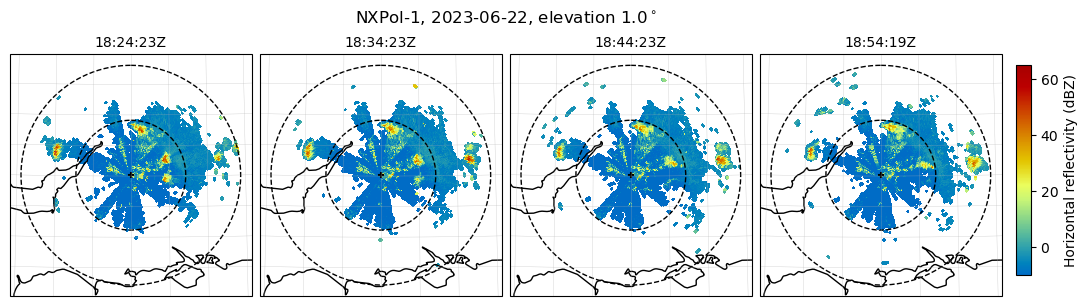

In [234]:
# choose number of rows/columns and figure height
ncols = 4
nrows = 1
fwidth = 10
fheight = 3
fig, axes = plt.subplots(nrows,ncols, figsize = (fwidth,fheight), subplot_kw={'projection':grid_projection}, constrained_layout= True)

# axes is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1D array
axes=axes.flatten()

for ax,file in zip(axes,files):

    radar_file = os.path.join(directory, file)
    radar = pyart.io.read(radar_file, delay_field_loading=True)
    display = pyart.graph.RadarMapDisplay(radar)
    
    ppi = display.plot_ppi_map('dBZ',
                     sweep = 0,
                     ax = ax, # set which axes to create the plot on 
                     embellish = False, # turn off embellishments such as coastlines
                     title_flag = False, # turn off title
                     projection = grid_projection, # set projection
                     colorbar_flag = False # turn off the colourbar so it doesn't appear on every subplot
                    )
    
    # add coastlines to plot
    ax.coastlines(resolution = '10m');
    
    # plot range ringes
    display.plot_range_rings([50,100],
                             ls = '--',
                             lw = '1')
    
    # plot cross hair
    display.plot_cross_hair(2000, ax = ax) 
    
    # add gridlines 
    gl = ax.gridlines(draw_labels=False,
                      dms = False,
                      x_inline=False,
                      y_inline=False,
                      rotate_labels=False,
                      alpha = 0.7,
                      zorder = 0,
                      linewidth = 0.25,
                      )
    gl.right_labels = gl.top_labels = False

    #get time to set as title for subplots
    time = radar.metadata['start_datetime'].split('T')[1]
    ax.set_title(time, fontsize = 10);

# Add a colourbar axis to the right
cbar_ax = fig.add_axes([1.01, 0.1, 0.015, 0.7])

# Draw the colourbar
display.plot_colorbar(cax=cbar_ax, label = 'Horizontal reflectivity (dBZ)')

# set up figure title and add 
start_date = radar.metadata['start_datetime'].split('T')[0]
elevation = np.unique(radar.elevation['data'])[sweep_idx]
instrument = 'NXPol-1'
title = f'{instrument}, {start_date}, elevation {elevation}$^\\circ$'
fig.suptitle(title, fontsize = 12);